# Laplacian Associative Memory (LAM) - AOV

[Multiscale representations of community structures in attractor neural networks](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8412329/pdf/pcbi.1009296.pdf) (2021)

In [1]:
import sys
sys.path.append('..')

In [2]:
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from nn_npy import LAM
import libtools

---

#### DATA

In [4]:
img = np.array(PIL.Image.open("../data/images/coco/mesh.png").convert('L'), dtype=float)
# img = libtools.downsample(img, 2) # Downsample
img = img[:100,:100] # Crop
img /= np.max(img)

print('Image:', img.shape)
print('min:', f"{img.min():.2f}", 'max:', f"{img.max():.2f}")

Image: (100, 100)
min: 0.02 max: 1.00


---

In [5]:
f = np.fft.fft2(img) # Frequency transform
fshift = np.fft.fftshift(f) # Shift zero frequency component (DC-component)
power = np.abs(fshift) # Process complex numbers
phase = np.angle(fshift)

In [6]:
# Define radial distance
nx, ny = power.shape
x = np.arange(-power.shape[0]//2, power.shape[0]//2)
y = np.arange(-power.shape[1]//2, power.shape[1]//2)
X, Y = np.meshgrid(x, y)
dist = np.sqrt(X**2 + Y**2)

# Compute spatial frequency
hist, bins = np.histogram(dist.flatten(), bins=np.arange(dist.max()), weights=power.flatten())

count = hist[1:].argmax()
print('Freqency at which power is greatest:', count)

Freqency at which power is greatest: 12


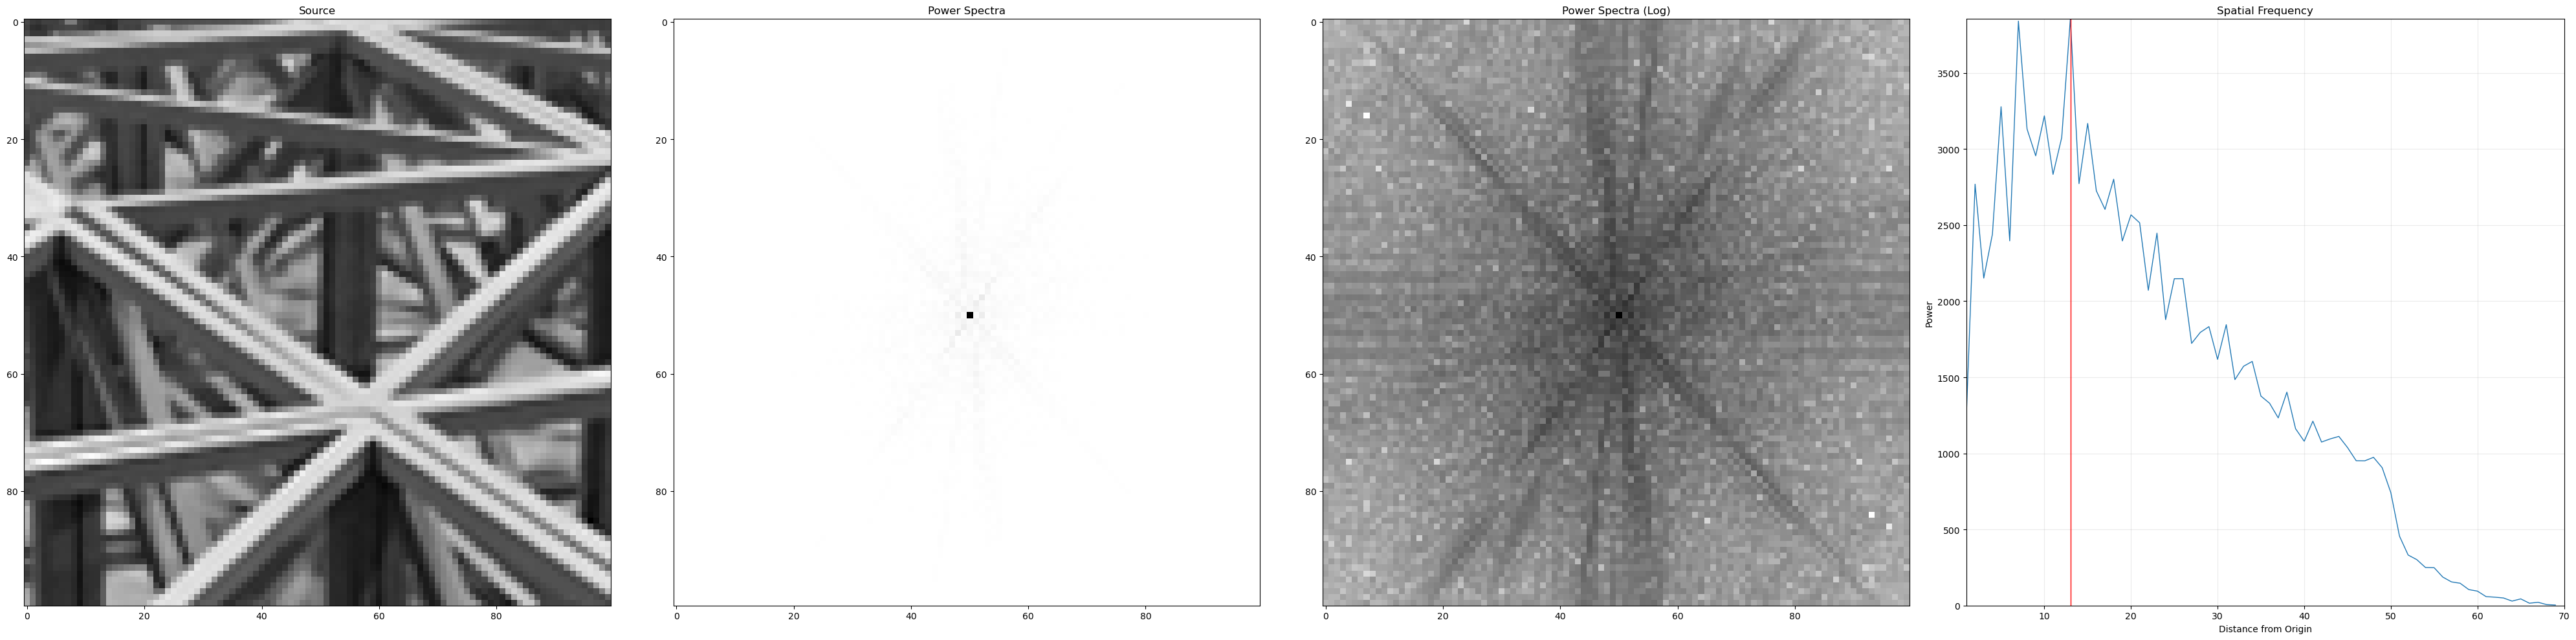

In [7]:
plt.figure(figsize=(40,10))
plt.subplot(1,4,1)
plt.imshow(img, 'gray')
plt.title('Source')

plt.subplot(1,4,2)
plt.imshow(power, 'binary')
plt.title('Power Spectra')

plt.subplot(1,4,3)
plt.imshow(np.log(power), 'binary')
plt.title('Power Spectra (Log)')

plt.subplot(1,4,4)
plt.plot(bins[:-1], hist, lw=1)
plt.vlines(count+1, 0, hist[1:].max(), linewidth=1, color='r')
plt.title('Spatial Frequency')
plt.xlabel('Distance from Origin'), plt.ylabel('Power')
plt.xlim([1,int(dist.max())]), plt.ylim([0,int(hist[1:].max())])
plt.grid(alpha=0.25)
plt.tight_layout()

---

In [8]:
src = libtools.preference_map(16, count*2, img.shape[0]) # x2 power of spatial frequency FFT
# np.save('../data/mat/SOM_orient_v2.npy', src)
# src = np.load('../data/mat/SOM_orient_v2.npy')

print('Map:', src.shape)
print('min:', f"{src.min():.2f}", 'max:', f"{src.max():.2f}")

Map: (100, 100)
min: 0.00 max: 6.28


In [9]:
features = libtools.gabor_conv(img, src, step=int(count)) # Power of spatial frequency FFT (No multiplicative factor)
features /= np.max(features)

print('Features:', features.shape)
print('min:', f"{features.min():.2f}", 'max:', f"{features.max():.2f}")

Features: (100, 100)
min: 0.00 max: 1.00


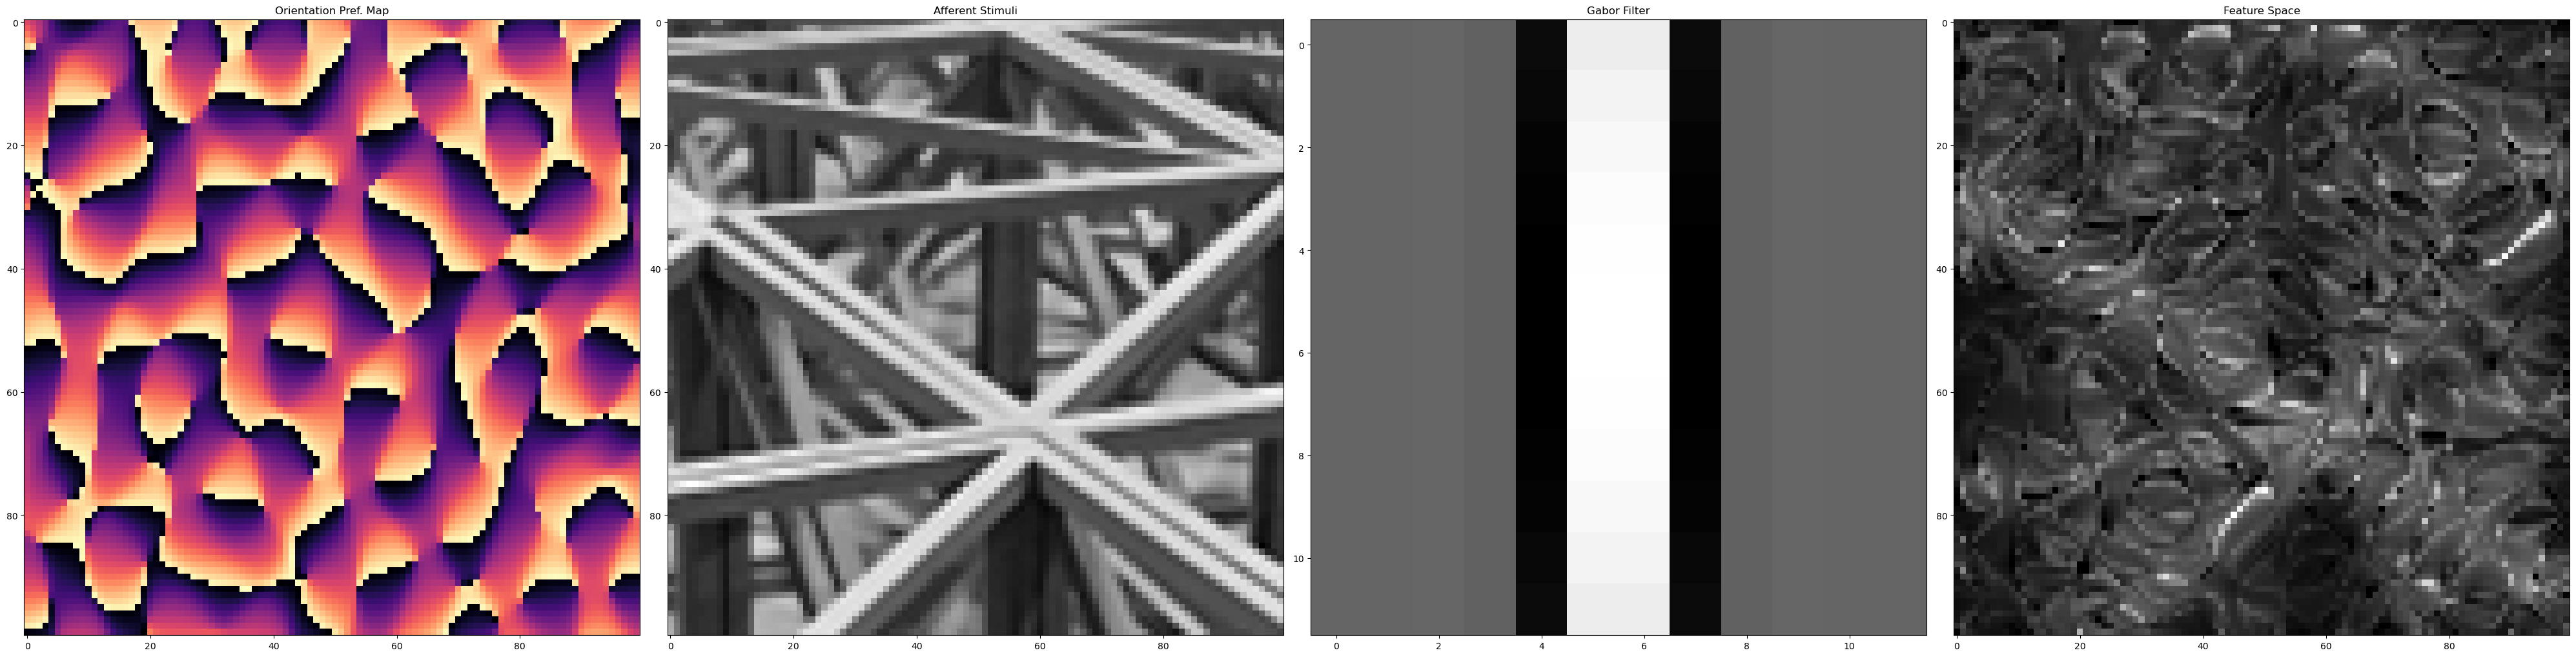

In [10]:
plt.figure(figsize=(40,10))
plt.subplot(1,4,1)
plt.imshow(src, 'magma')
plt.title('Orientation Pref. Map')

plt.subplot(1,4,2)
plt.imshow(img, 'gray')
plt.title('Afferent Stimuli')

plt.subplot(1,4,3)
plt.imshow(libtools.gabor_filter(1,10,0, samples=int(count)), 'gray')
plt.title('Gabor Filter')

plt.subplot(1,4,4)
plt.imshow(features, 'gray')
plt.title('Feature Space')
plt.tight_layout()

---

### HYPER-PARAMETERS

In [11]:
N = 128**2                              # Units | Default: 30000
prob = 0.1                              # Sparsity
eta = 0.01                              # Epsilon / Learning rate
simlen = 3000                           # Steps / Epochs
gamma = 0.6                             # Inhibition ratio
norm_mode = 'asym'                      # Asymmetric Normalisation
alpha = -0.9                            # Ratio between local and global inhibition
P = src.shape[0] * src.shape[1]         # N Nodes

sigmaX = 1e-5                           # Spatial Gaussian Scale
sigmaA = 0.1                            # Angular Gaussian Scale

# Init condition (Center cell/pixel)
start_node = int(int(src.shape[0]/2) * src.shape[1] + int(src.shape[0]/2))

print('Nodes:', N)
print("Neurons:", P)
print('Start node:', start_node)
print(f"{P * 0.138:.2f} point attactors")

Nodes: 16384
Neurons: 10000
Start node: 5050
1380.00 point attactors


---

### COMPUTE

In [12]:
W = libtools.construct_SLAM(src, sigmaX, sigmaA) # Correlation Matrix

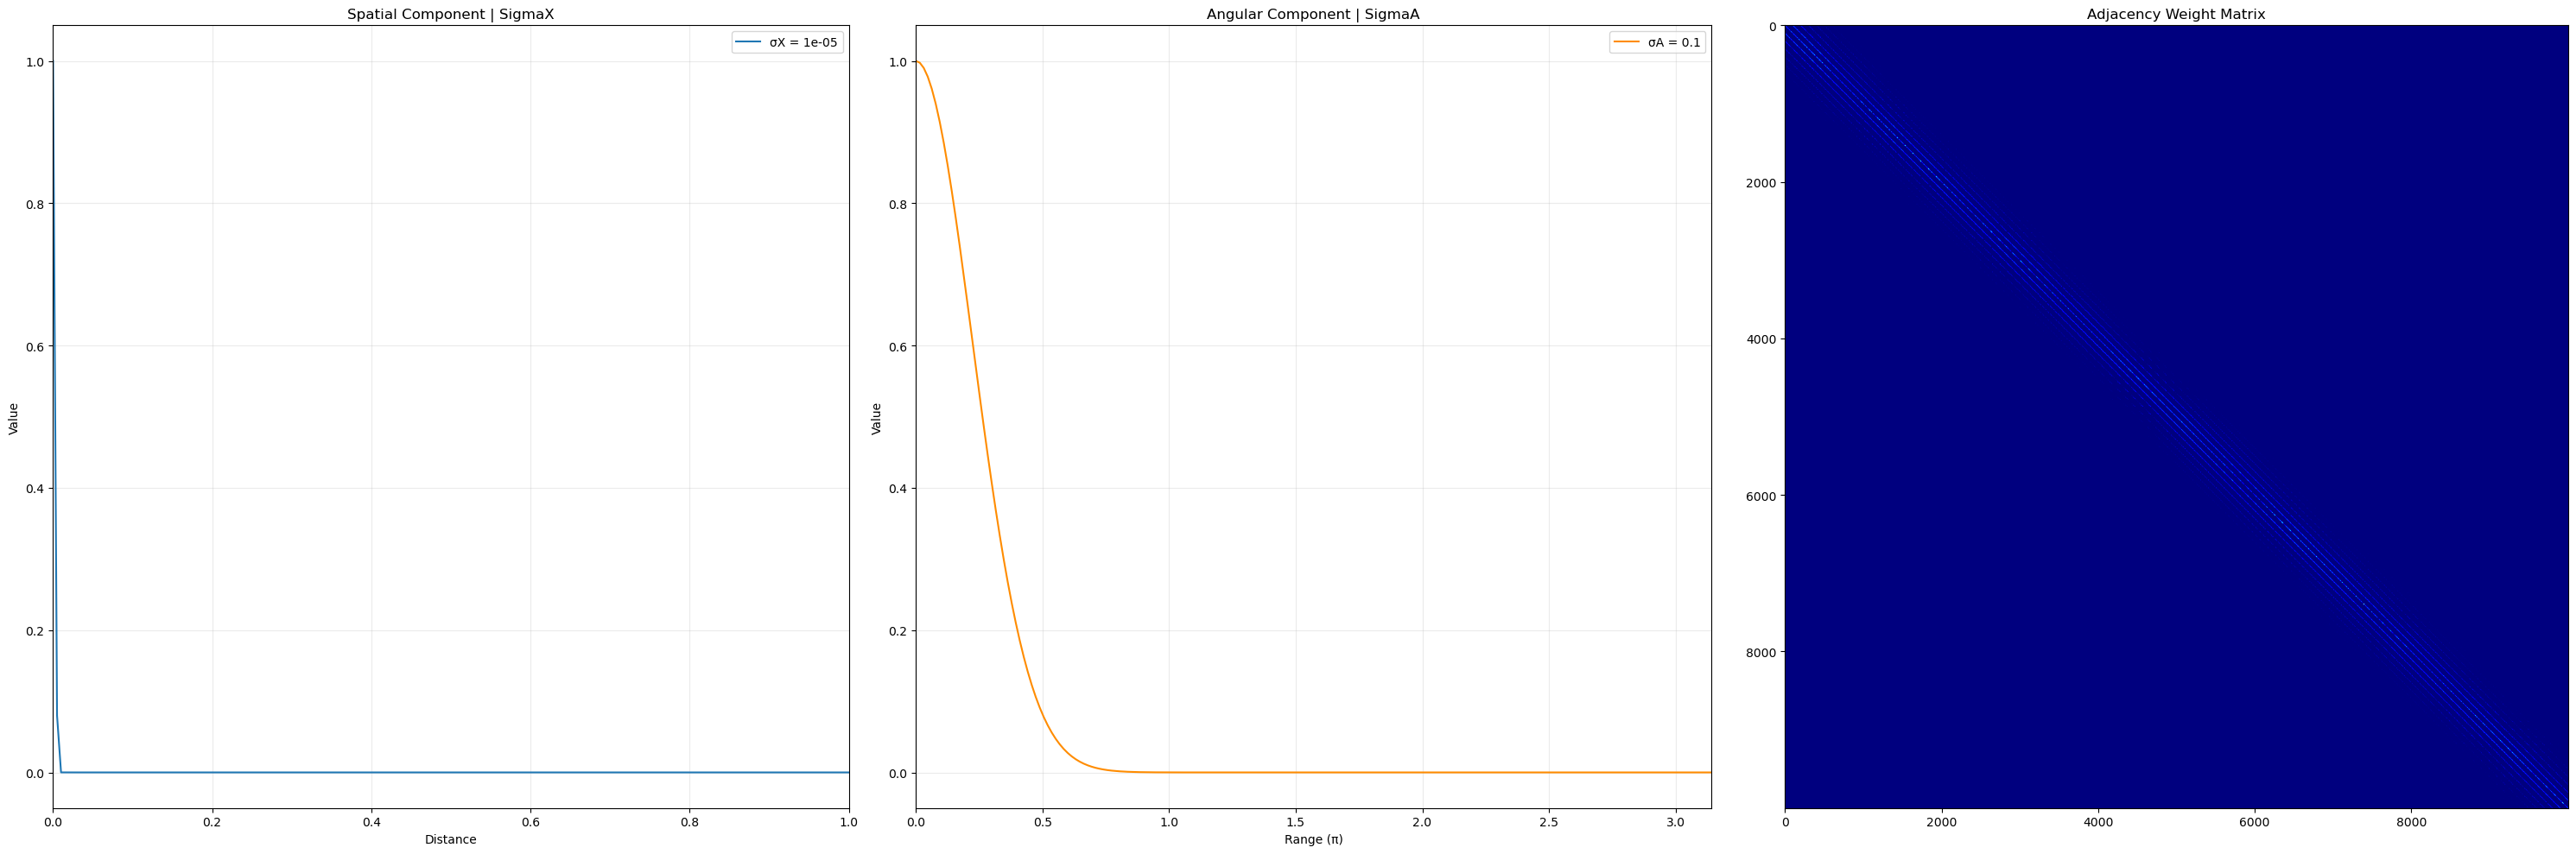

In [13]:
plt.figure(figsize=(30,10))
plt.subplot(1, 3, 1)
dist_s = np.linspace(0, 1, 200)
plt.plot(dist_s, libtools.gaussian(dist_s, sigmaX), label=f'σX = {sigmaX}')
plt.title('Spatial Component | SigmaX')
plt.xlabel('Distance'), plt.ylabel('Value')
plt.xlim([0, 1]), plt.grid(alpha=0.25), plt.legend()

plt.subplot(1, 3, 2)
dist_a = np.linspace(0, np.pi, 200)
plt.plot(dist_a, libtools.gaussian(dist_a, sigmaA), 'darkorange', label=f'σA = {sigmaA}')
plt.title('Angular Component | SigmaA')
plt.xlabel('Range (π)'), plt.ylabel('Value')
plt.xlim([0, np.pi]), plt.grid(alpha=0.25), plt.legend()

plt.subplot(1, 3, 3)
plt.imshow(W, cmap='jet')
plt.title('Adjacency Weight Matrix')
plt.tight_layout()

---

In [14]:
Dnorm_asym = np.diag(np.sum(W, axis=1)**-1) # ASYMMETRIC normalized degree matrix
L = np.eye(P) - Dnorm_asym @ W # Laplacian Matrix

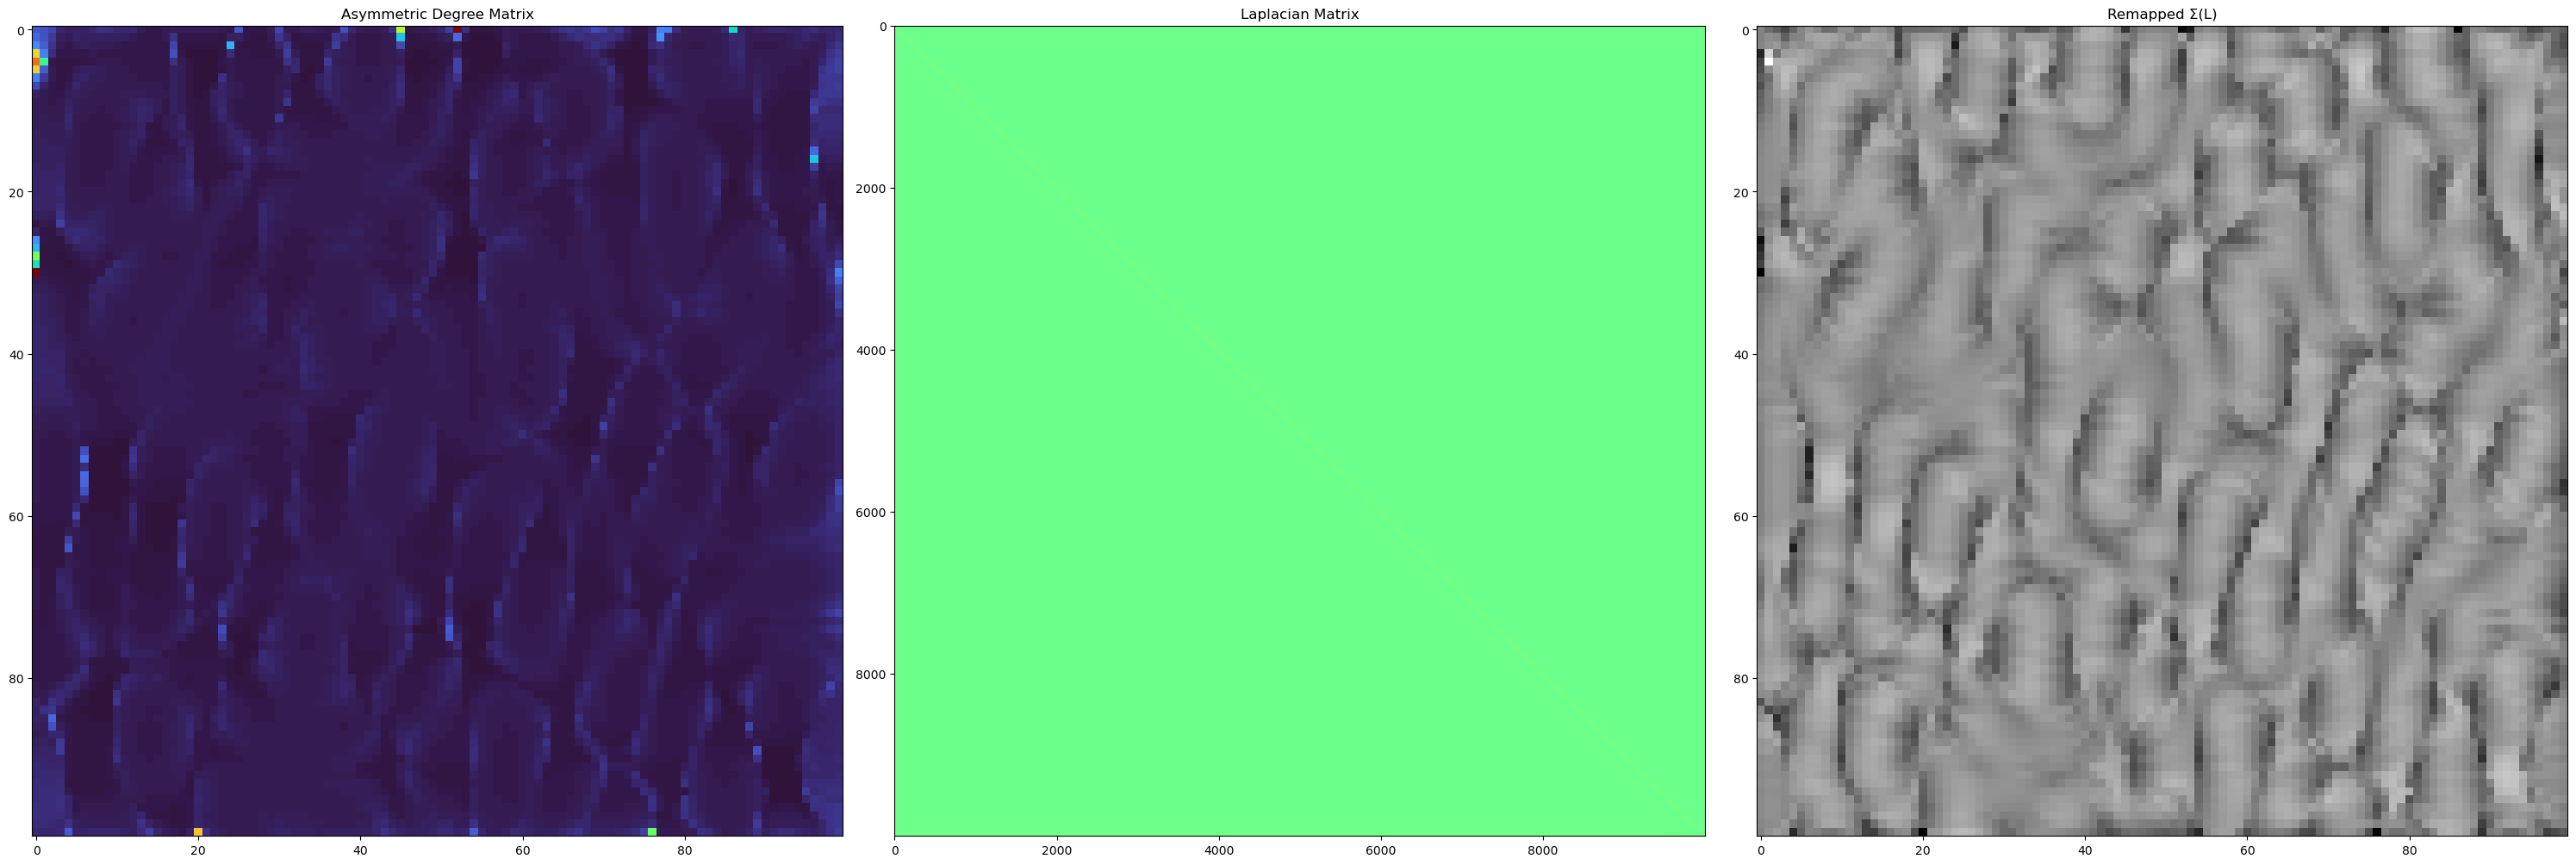

In [15]:
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(np.sum(Dnorm_asym, axis=1).reshape(src.shape), cmap='turbo')
plt.title('Asymmetric Degree Matrix')

plt.subplot(1,3,2)
plt.imshow(L, cmap='jet')
plt.title('Laplacian Matrix')

plt.subplot(1,3,3)
plt.imshow(np.sum(L, axis=0).reshape(src.shape), cmap='binary')
plt.title('Remapped Σ(L)')
plt.tight_layout()

---

In [16]:
e, v = libtools.GL_eigen(W, norm_mode='asym')

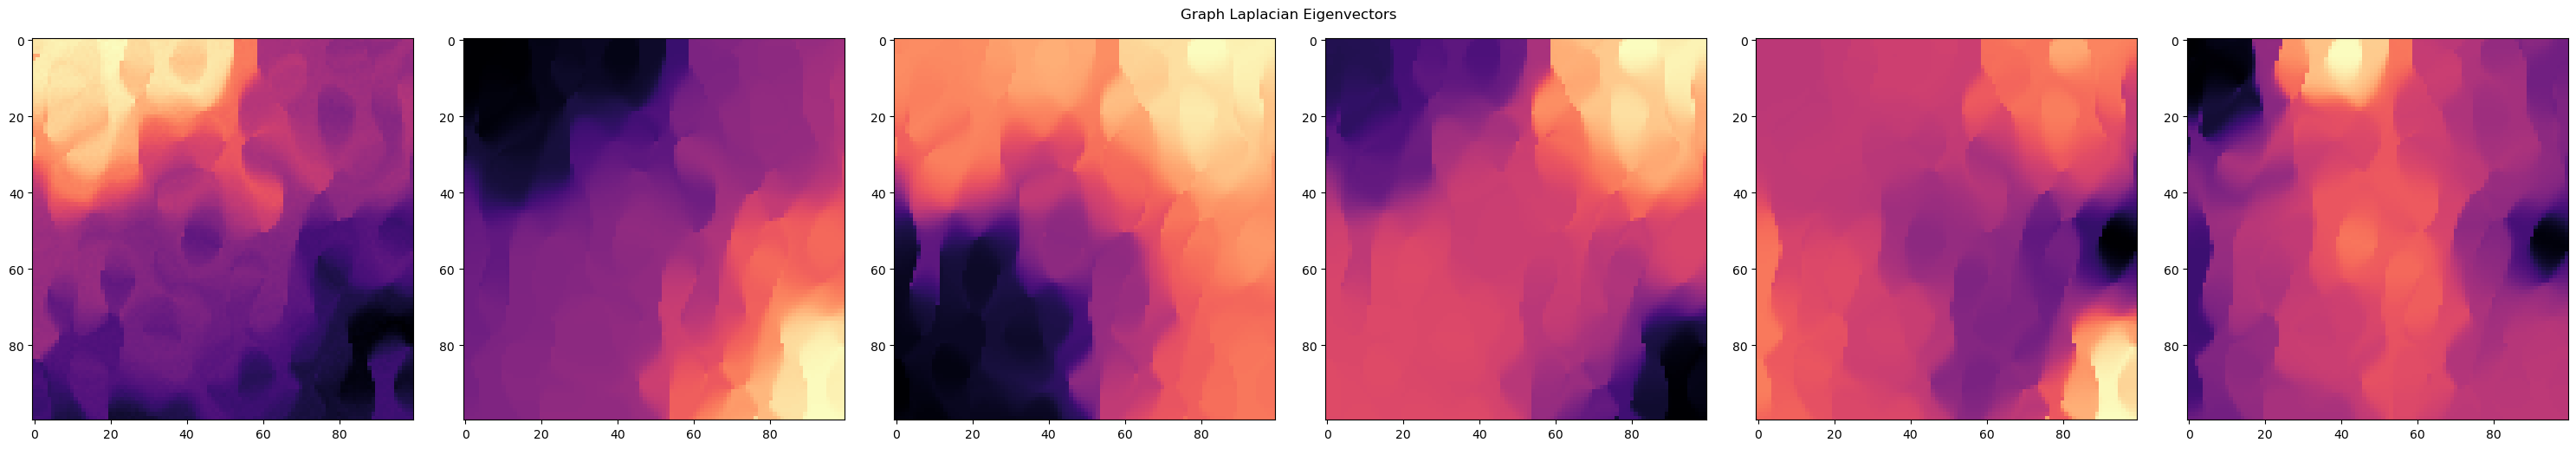

In [17]:
plt.figure(figsize=(30,5))
for k in range(6):
    plt.subplot(1, 6, k+1)
    plt.imshow(v[:,k].reshape((src.shape)), cmap="magma", vmin=np.min(v[:,k]), vmax=np.max(v[:,k]))
    
plt.suptitle('Graph Laplacian Eigenvectors')
plt.tight_layout()

---

In [18]:
graph = LAM(N, P, prob, W, gamma, "asym") # Decompose Weights

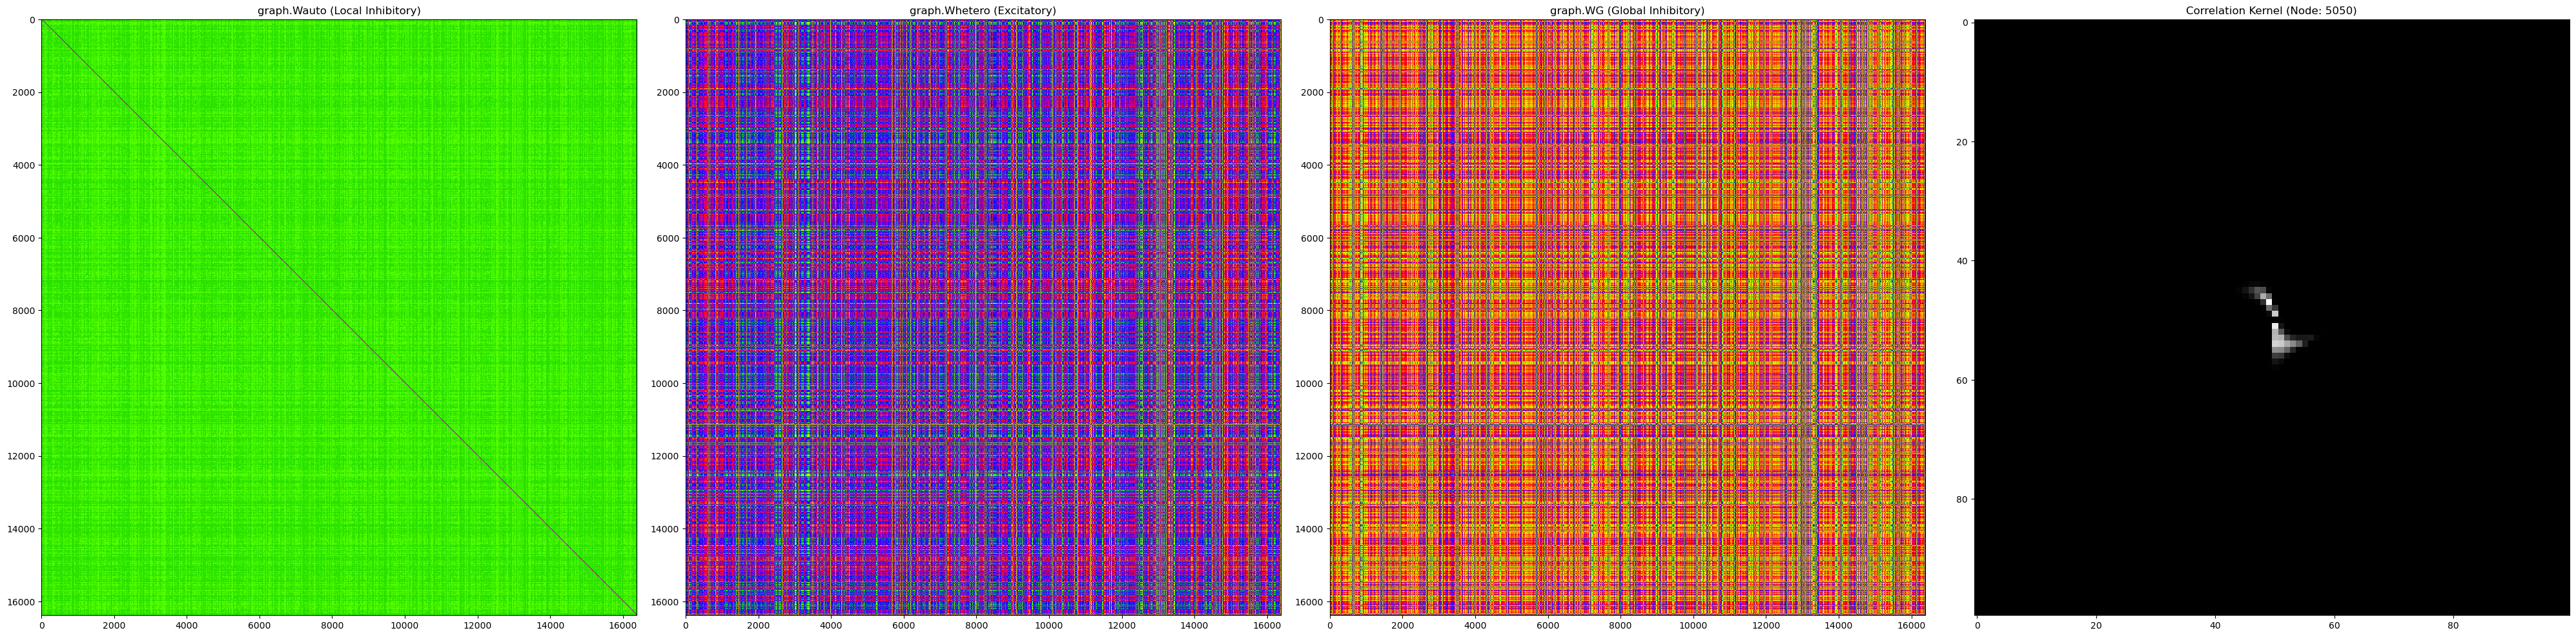

In [19]:
plt.figure(figsize=(40,10))
plt.subplot(1, 4, 1)
plt.imshow(graph.Wauto, cmap='prism')
plt.title('graph.Wauto (Local Inhibitory)')

plt.subplot(1, 4, 2)
plt.imshow(graph.Whetero, cmap='prism')
plt.title('graph.Whetero (Excitatory)')

plt.subplot(1, 4, 3)
plt.imshow(graph.WG, cmap='prism')
plt.title('graph.WG (Global Inhibitory)')

plt.subplot(1, 4, 4)
plt.imshow(W[start_node].reshape(src.shape), 'gray')
plt.title('Correlation Kernel (Node: ' + str(start_node) + ')')
plt.tight_layout()

---

In [27]:
init_state = libtools.set_state(graph, features, 0.0915)
print("Sparsity:", np.sum(init_state/np.size(init_state)))

Sparsity: 0.100830078125


In [28]:
m_log, p_log, e_log = graph.simulate_single(alpha, eta, simlen, start_node, init_state.copy()) # Simulate

Using feature-based initial condition


100%|██████████| 3000/3000 [06:37<00:00,  7.56it/s]


In [29]:
m = m_log[-1,:].copy()
# m[start_node] = np.mean(np.delete(m, start_node))

# Nactive = np.mean(np.sum((m > 0.5*np.max(m)), axis=0))
Nactive = np.mean(np.sum((m > 0.5*np.max(m)) * (m > 0.0), axis=0))
print("Maximum overlap:", np.max(m))
print("Number of patterns:", Nactive)

Maximum overlap: 0.003707421480800544
Number of patterns: 41.0


---

### PLOT

In [30]:
# HSV2RGB
m_norm = m + abs(m.min())
m_norm /= m_norm.max()

hsv_pattern = libtools.grade(src/(2*np.pi), 1.0, m_norm.reshape(src.shape))
hsv_features = libtools.grade(src/(2*np.pi), 1.0, features.reshape(src.shape))

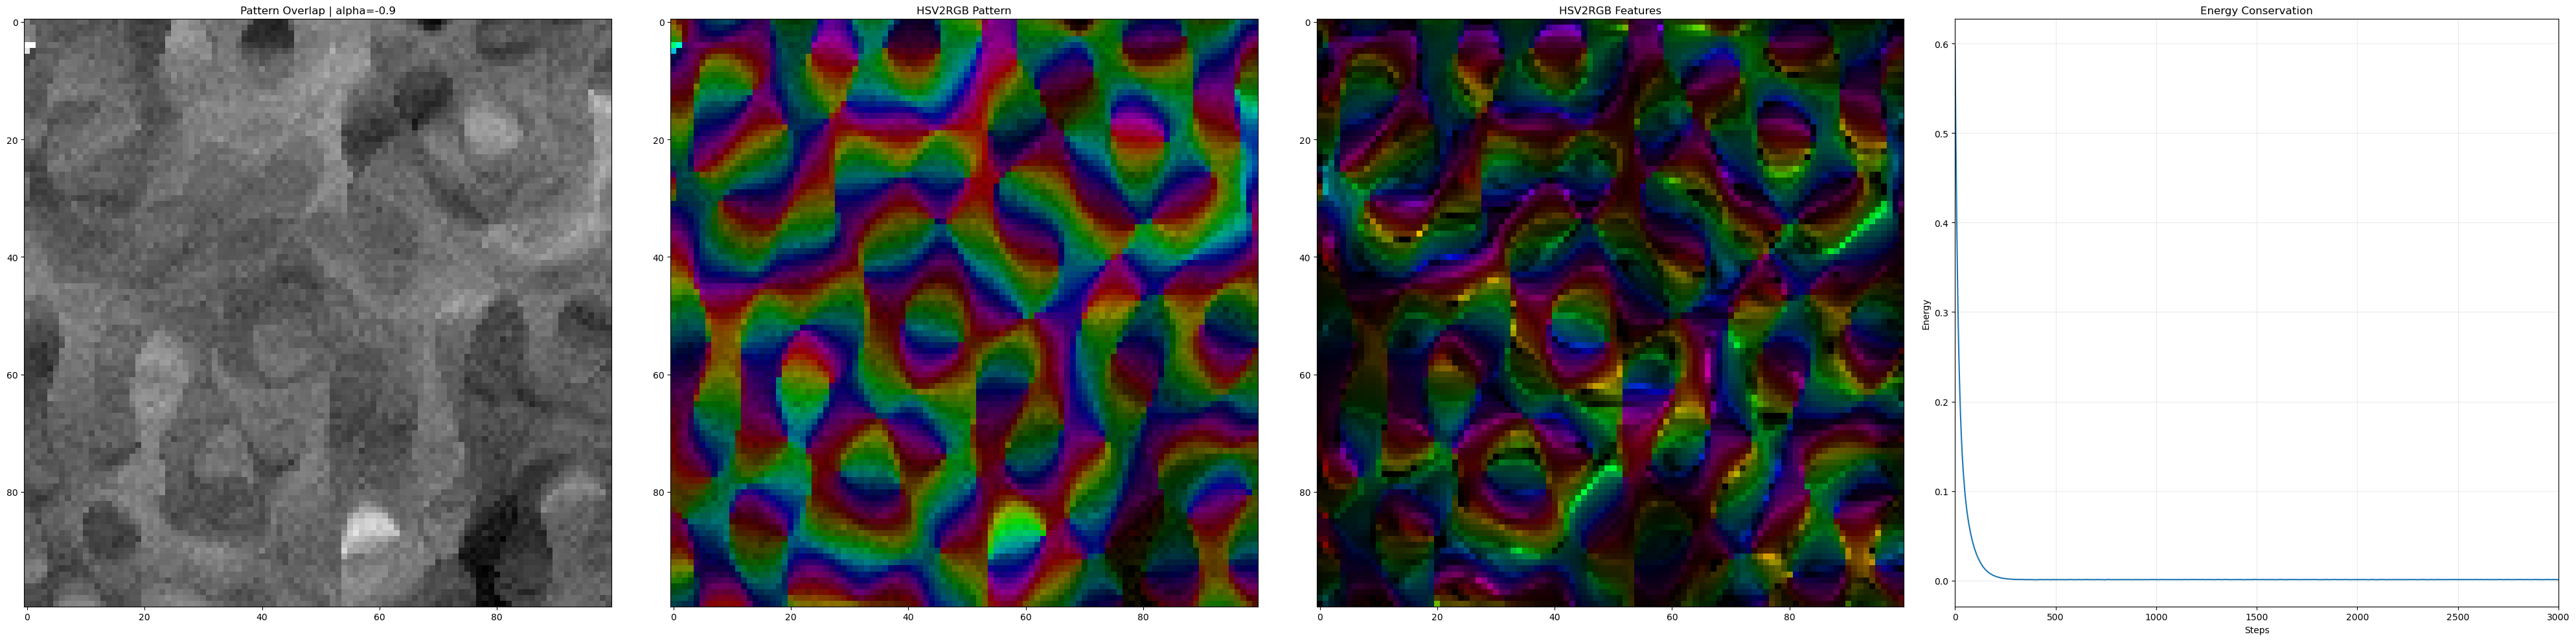

In [31]:
plt.figure(figsize=(40,10))
plt.subplot(1, 4, 1)
plt.imshow(m.reshape(src.shape), 'gray')
plt.title("Pattern Overlap | alpha=" + str(alpha))

plt.subplot(1, 4, 2)
plt.imshow(hsv_pattern)
plt.title("HSV2RGB Pattern")

plt.subplot(1, 4, 3)
plt.imshow(hsv_features)
plt.title("HSV2RGB Features")

plt.subplot(1, 4, 4)
plt.plot(e_log)
plt.title("Energy Conservation")
plt.xlabel("Steps"), plt.ylabel("Energy")
plt.xlim(0,simlen)
plt.grid(alpha=0.25)
plt.tight_layout()

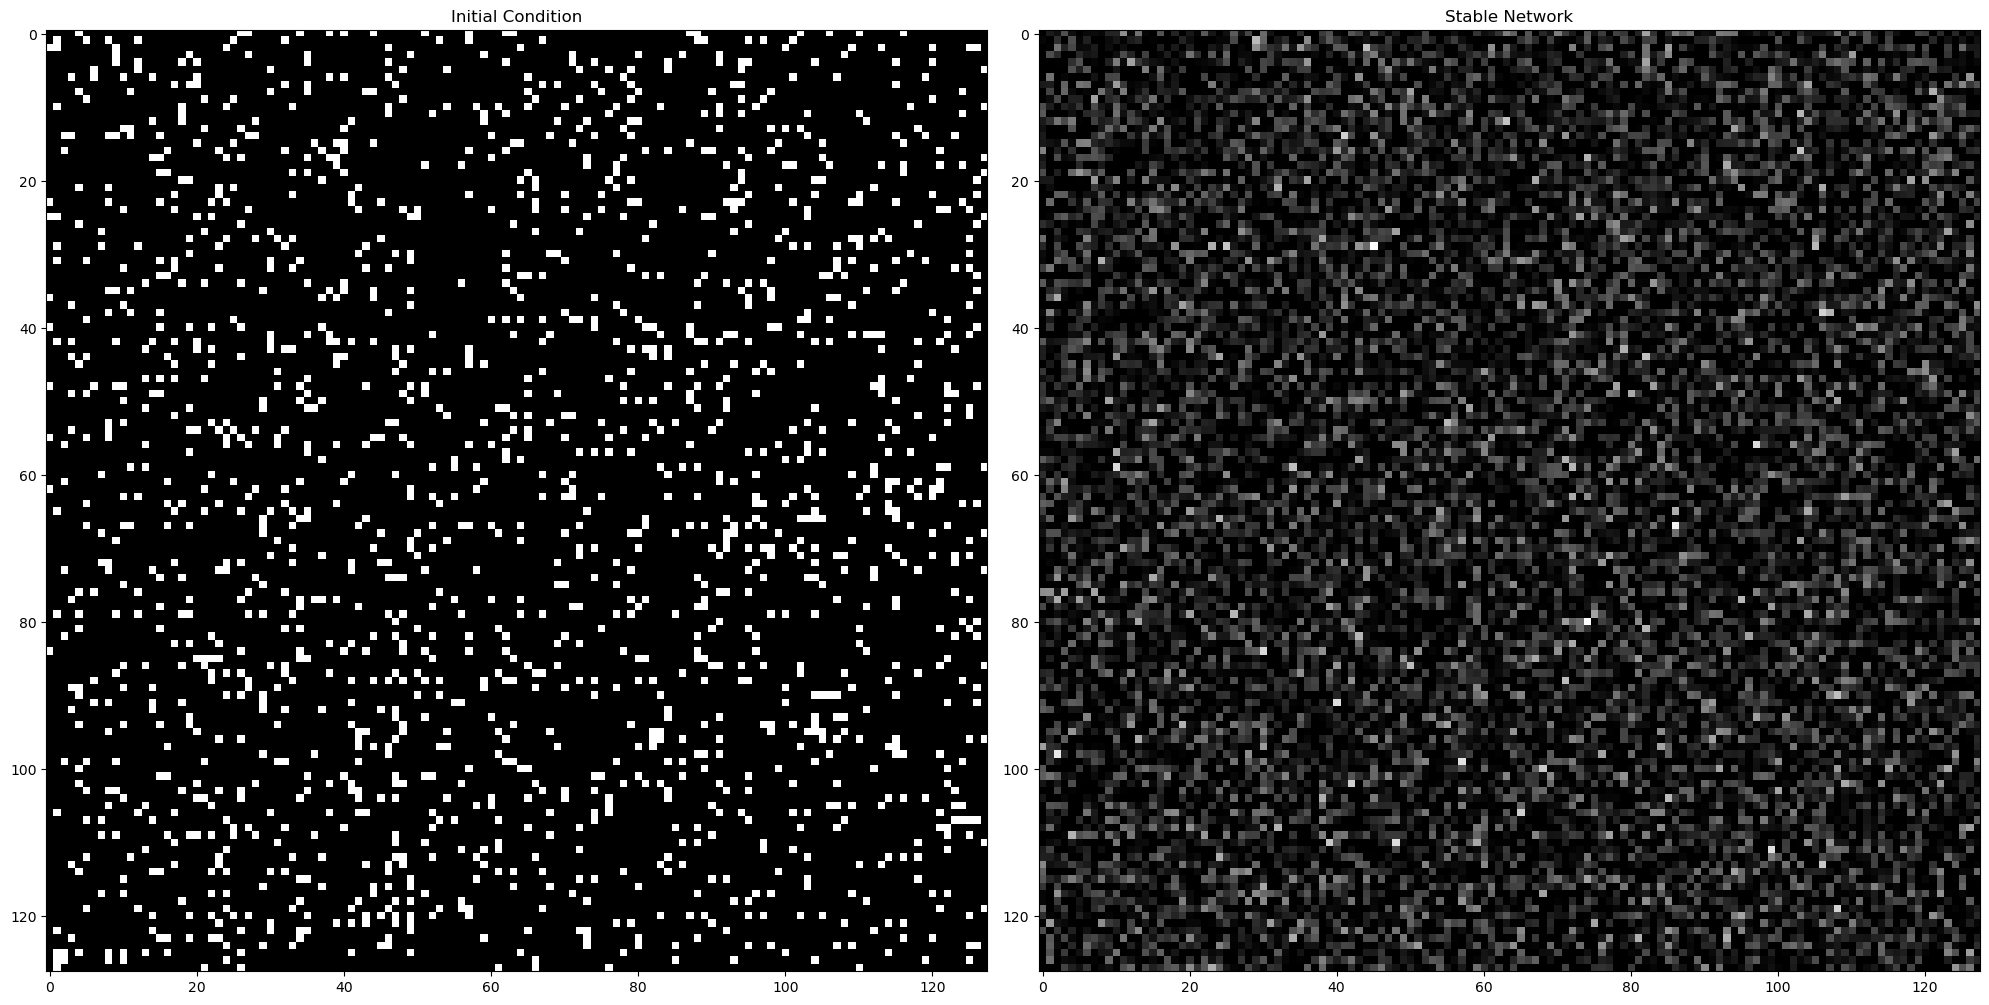

In [32]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
dim = int(N**0.5)
plt.imshow(graph.xi[:, start_node].reshape([dim,dim]), 'gray')
plt.title("Initial Condition")

plt.subplot(1, 2, 2)
plt.imshow(graph.x.reshape([dim,dim]), 'gray')
plt.title("Stable Network")
plt.tight_layout()